# Projections de triangle de liquidations

## Chargement des données et des packages nécessaires

In [5]:
require(forecast)
require(TSA)
require(fArma)
require(smooth)
require(Mcomp)
data<-read.csv("/home/tantely/Documents/IMSA/Projet_TER/otherliab_pos.csv")

Dans toute cette partie, on va essayer de travailler avec le tableau de paiement de 1988 à 1996. Donc pour cela, on va réduire la taille de  nos données avec la fonction qui est ci-dessous.

In [6]:
Clear_repar_data<-function(Pdata,retire=10){
    ret_ind=(length(Pdata)-retire+1):length(Pdata)
    temp=Pdata[-ret_ind]
    temp1=rep(0,(retire-1)^2)
    for(i in 0:(retire-2)){
        temp1[(1:(retire-1))+(retire-1)*i]=temp[1:(retire-1)+i*retire]
    }
    return(temp1)
}

In [7]:
paid_loss<-Clear_repar_data(data$NonCumPaidLoss)
#paid_loss<-data$NonCumPaidLoss


## Construction du triangle de paiement

In [8]:
Mat_tri<-function(X,r){
    M=matrix(rep(0,r*r),ncol=r,nrow=r)
    ligne=1:r+1987
    colonne=1:r-1
    rownames(M)=ligne
    colnames(M)=colonne
    for(i in 0:(r-1)){
       for(j in 0:(r-1)){
           if(i+j<r){
           M[i+1,j+1]=X[i*r+j+1]   
           }
       }
   }
    return(M)
}

In [9]:
Mat_tri(paid_loss,r=9)

,0,1,2,3,4,5,6,7,8
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423
1989,6387,11455,17587,21793,23569,14359,8581,8719,0
1990,8347,9675,18736,34779,16084,13192,20976,0,0
1991,7700,13802,21770,21111,14189,14470,0,0,0
1992,8223,14958,14195,14665,20570,0,0,0,0
1993,12122,14034,22678,34075,0,0,0,0,0
1994,7596,11808,46103,0,0,0,0,0,0
1995,10264,34552,0,0,0,0,0,0,0
1996,20162,0,0,0,0,0,0,0,0


## extraction des paiements annuels

In [10]:
Y_serie<-function(X,r=10){
   n=r*(1+r)/2
   M=Mat_tri(X,r)
   Y=rep(0,n)
   for(j in 1:r){
       I=((j-1)*j/2+1):((j-1)*(j+2)/2+1)
       tj=(j-1)*j/2+1
       for(t in I){
           Y[t]=M[abs(tj+j-t),abs(t-tj+1)]
       }
   }
    return(Y)
}

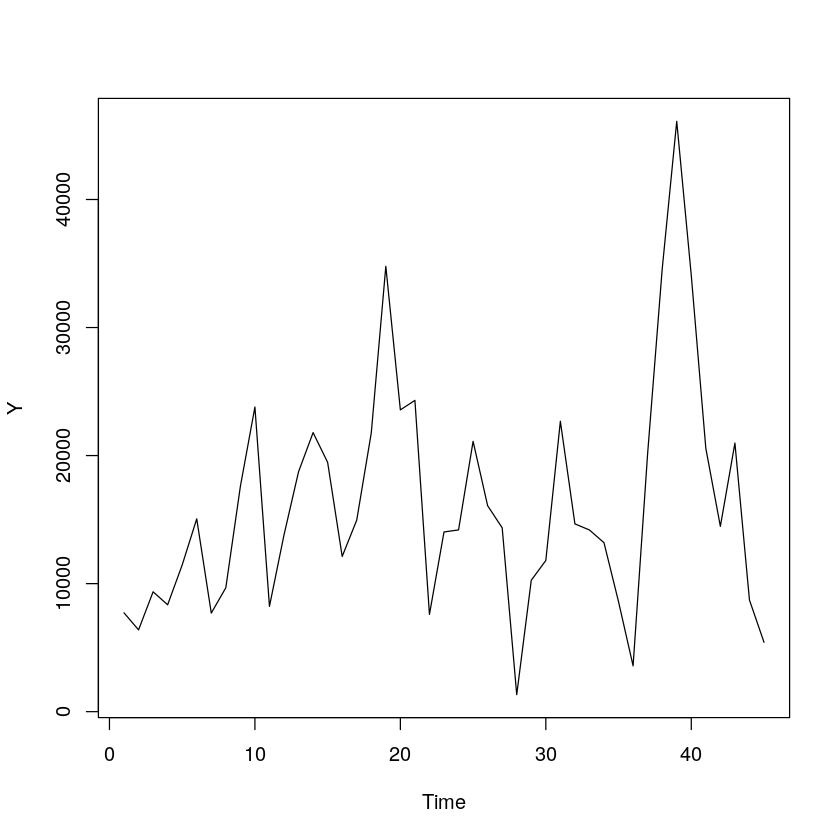

In [11]:
Y=Y_serie(paid_loss,r=9)
ts.plot(Y)
Y=log(Y)

## Modélisation de la série:
On va prendre comme hypothèse où la série $Y_t$ peut se modéliser en modèle multiplicatif. Cela va nous assurer la positivité des résultats que l'on va avoir dans la matrice de paiement. Pour passer d'un modèle additif qui est plus simple à étudier, on a pris ci-dessus le logarithme de notre série $Y_t$

### Echantillon test et echantillon d'apprentissage:

In [12]:
fit.train<-Y[1:40]
fit.test<-Y[41:45]

# Tendance de la série
Maintenant, on va étudier la présence de tendances dans notre série $Y_t$. Pour cela on va d'abord regarder s'il y a présence de tendances ou non grâce au test de du signe de la différence.

In [13]:
signe_difference<-function(vector){
  n=length(vector)
  U=rep(0,n-1)
  if(n>1){
    if(vector[2]>vector[1]){
      U[1]=1
    }
  
    for(i in 2:(n-1)){
      if(vector[i+1]>vector[i]){
        U[i]=1
      }else{
        U[i]=0
      }
    }
  }
  W=(sum(U)-(n-1)/4)/((n+1)/12)
  res=""
  if(abs(W)>1.96){
    return(list(W_stat=abs(W),commentaire="La série possède une tendance"))
  }else{
    return(list(W_stat=abs(W),commentaire="La série ne possède pas de tendance"))
  }
}

In [14]:
signe_difference(Y)

$W_stat
[1] 3.130435

$commentaire
[1] "La série possède une tendance"

Comme on peut le voir, $Y_t$ possède une tendance. 

 ### Estimation de la tendance:

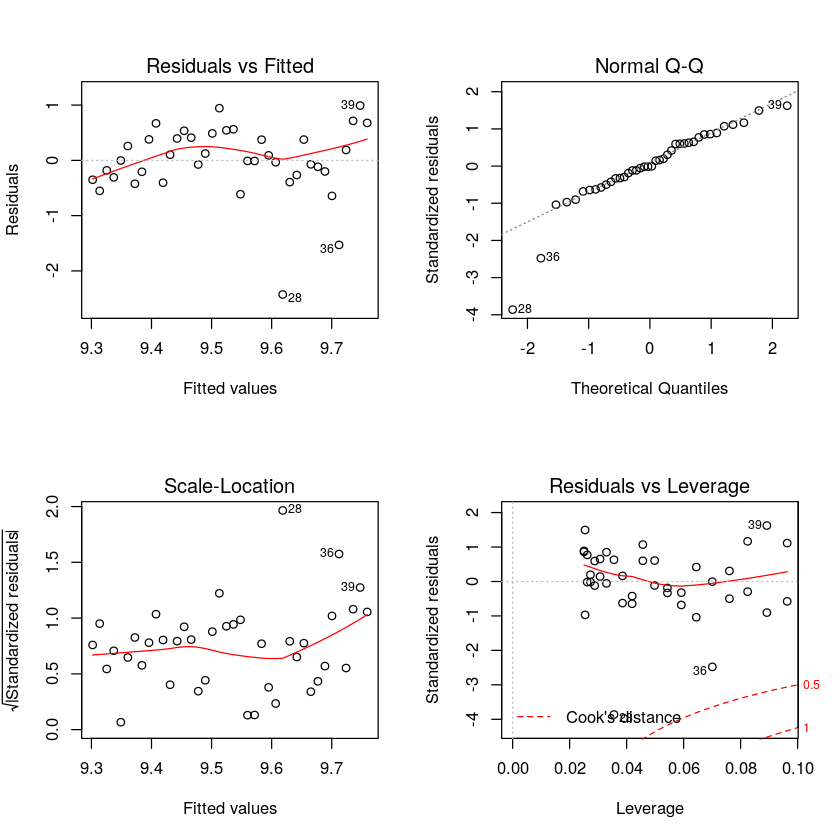

In [15]:
X_mod=fit.train
t1=time(fit.train)
lm.res<-lm(X_mod~t1)
#summary(lm.res)
par(mfrow=c(2,2))
plot(lm.res)

In [16]:
summary(lm.res)


Call:
lm(formula = X_mod ~ t1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.42699 -0.27588 -0.00667  0.39929  0.99132 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.290328   0.206229  45.048   <2e-16 ***
t1          0.011718   0.008766   1.337    0.189    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.64 on 38 degrees of freedom
Multiple R-squared:  0.04491,	Adjusted R-squared:  0.01978 
F-statistic: 1.787 on 1 and 38 DF,  p-value: 0.1893


Comme la tendance qui est estimée n'est pas significative $95 \%$, on va quand même prendre cette droite de régression de la tendance et considérer un autre équation de la tendance mais qui soit quadratique après.

# saisonnalité de notre série
Pour commencer, on va d'abord tester la présence de saisonnalités dans notre série par l'utilisation de du périodogramme et les fonctions Acf et pacf.

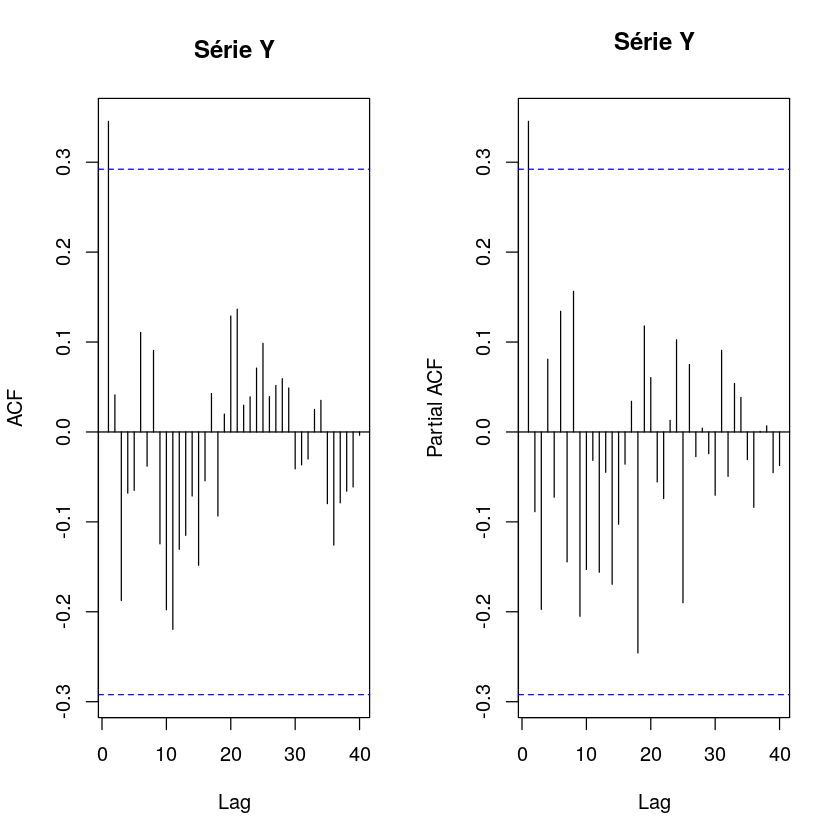

In [17]:
par(mfrow=c(1,2))
acf(Y,main="Série Y",lag=40)
pacf(Y,main="Série Y",lag=40)

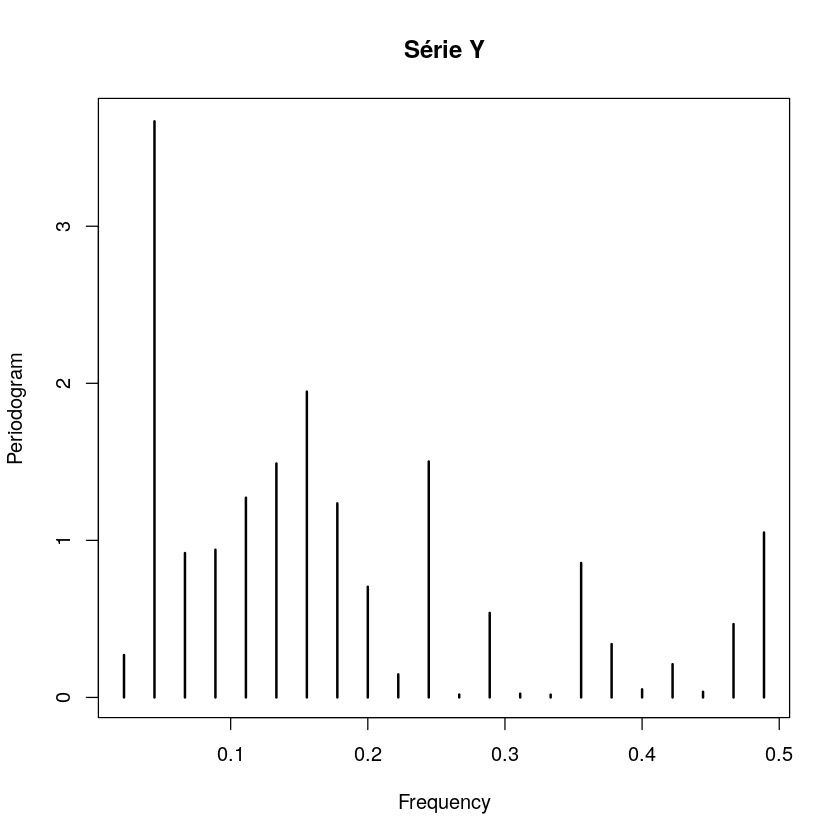

In [18]:
per=periodogram(Y,main="Série Y")
floorD=floor(length(Y)/which.max(per$spec))

[1] 6

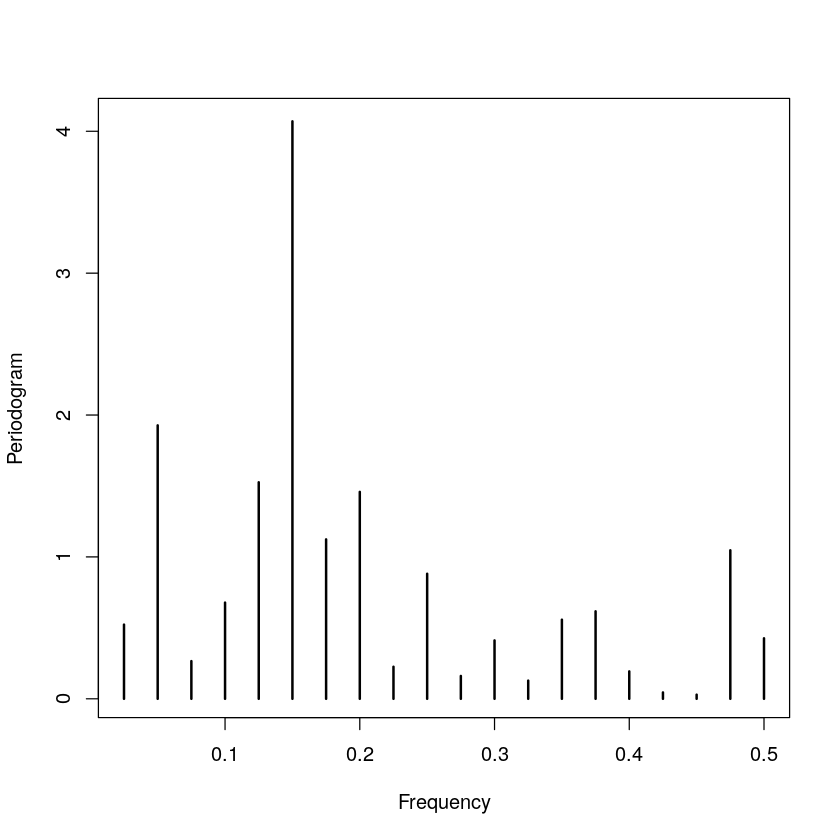

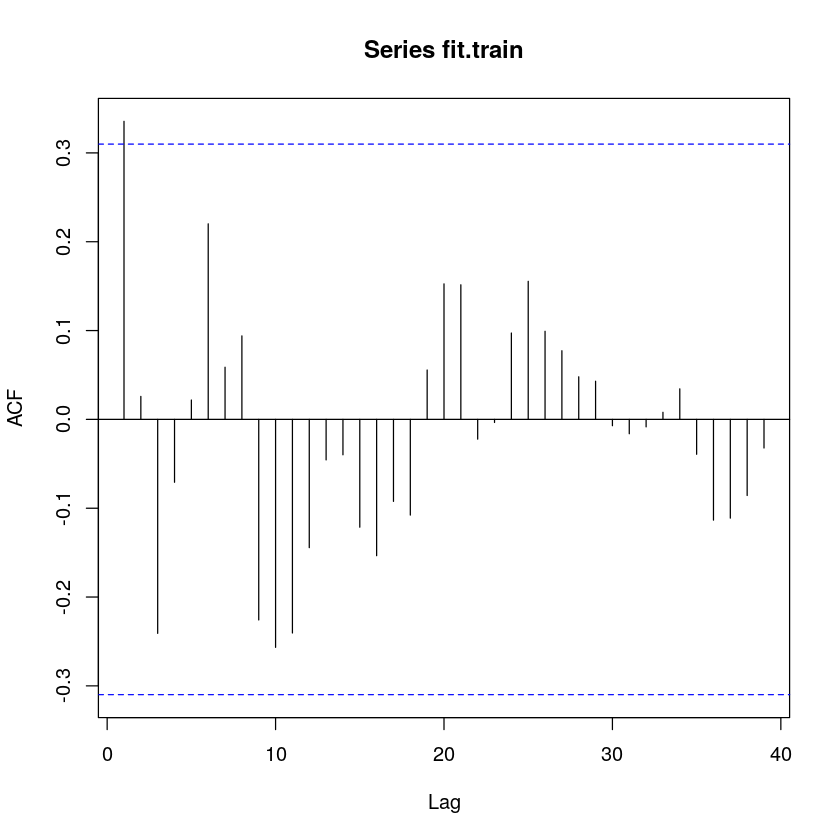

In [19]:
per1=periodogram(fit.train)
which.max(per1$spec)
floorD=floor(length(fit.train)/which.max(per1$spec))
acf(fit.train,lag=40)


## Estimation de la saisonnalité:
On va réaliser cette estimation par l'utilisation de la moyenne mobile.

## Fonction pour la moyenne mobile

In [21]:
Moyenne_mobile<-function(X,t,Ta=12,da=4){
  if((t<=da%/%2)|(t>Ta-da%/%2)){
    return(0)
  }
  coeff=c()
  q=da%/%2
  
  #Cas où d est impaire
  if(da%%2==1){
    coeff=rep(1/da,2*q+1)
  }else{ # Sinon d est paire
    for(j in -q:q){
      if(abs(j)==q){
        coeff=c(coeff,1/(4*q))
      }else{
        coeff=c(coeff,1/(2*q))
      }
    }
  }
  res=rep(0,2*q+1)
  for(i in -q:q){
     res[i+q+1]=coeff[i+q+1]*X[t-i]
   }
  return(sum(res))
}

## Fonction pour construire la saisonnalité:

In [23]:
saison2_fontion<-function(vect,T=12,d=4){
  J=floor(T/d)-1
  X<-vect
  W=rep(0,d)
  S1=rep(0,d)
  # Application de la formule 
  for(k in 1:d){
    temp=0
    for(j in 0:J){
      temp=temp+X[k+d*j]-Moyenne_mobile(X,t=k+d*j,Ta=T,da=d)
    }
    W[k]=temp/J
  }
  
  S1=W-sum(W)/d
  # Condition qui nous permet d'avoir la somme des saisons S_k égale à 0.
  S1=S1-sum(S1)/d
  res=c()
  #On repete (T/d) fois la tendance.
  for(i in 1:(floor(T/d))){
    res=c(res,S1)
  }
    return(res)
}

In [24]:
Equa=lm.res$coefficients[1]+lm.res$coefficients[2]*t1
extract=fit.train-Equa

[1] 36

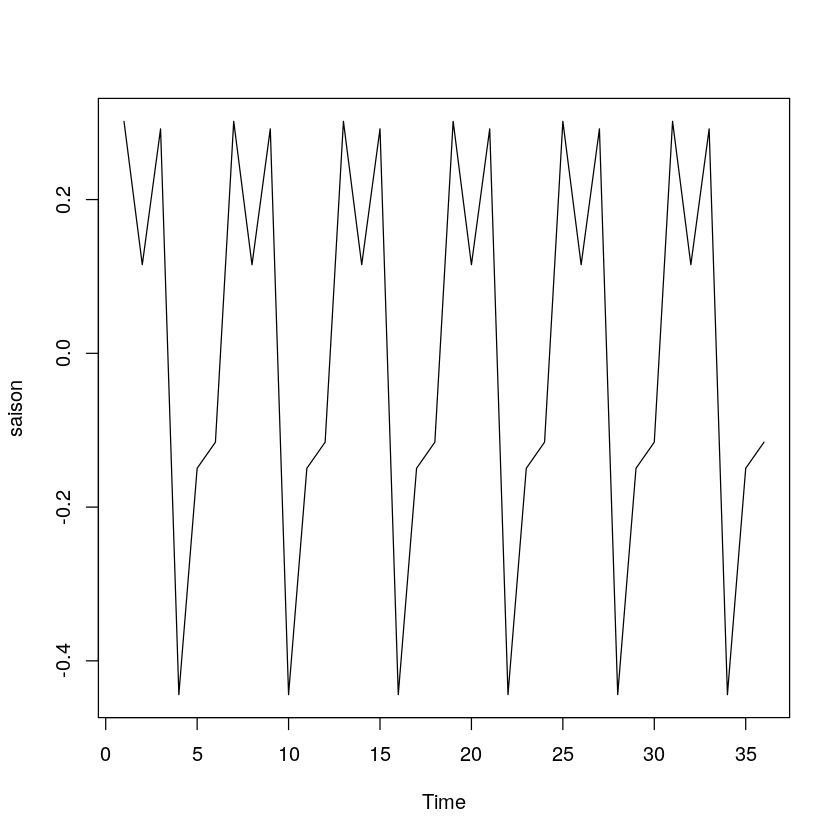

In [25]:
saison=saison2_fontion(extract,T=length(fit.train),d=floorD)
ts.plot(saison)
length(saison)

### Estimation du bruit pour un modèle à tendance linéaire:

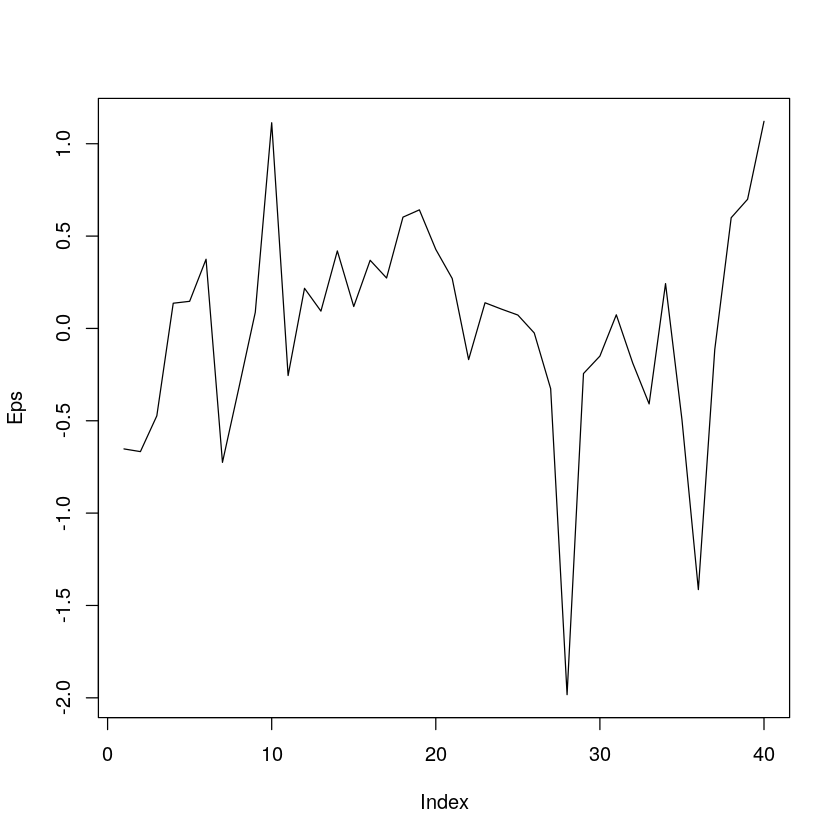

In [26]:
a_h=lm.res$coefficients[1]
b_h=lm.res$coefficients[2]
res_tend=lm.res$residuals

U=b_h*time(fit.train)+a_h
# On ajoute les trois prochaine éléments de la saison vu que len(saison)=45
Eps=fit.train-(U+c(saison,saison[1:4]))
plot(Eps,type="l")

### Présence de stationnarité ou non

In [27]:
pp.test(Eps)#with unit root
kpss.test(Eps)
adf.test(Eps)


	Phillips-Perron Unit Root Test

data:  Eps
Dickey-Fuller Z(alpha) = -22.478, Truncation lag parameter = 3, p-value
= 0.01909
alternative hypothesis: stationary


Warning message in kpss.test(Eps):
“p-value greater than printed p-value”


	KPSS Test for Level Stationarity

data:  Eps
KPSS Level = 0.12655, Truncation lag parameter = 1, p-value = 0.1



	Augmented Dickey-Fuller Test

data:  Eps
Dickey-Fuller = -2.1106, Lag order = 3, p-value = 0.5301
alternative hypothesis: stationary


Comme la p-value est inférieur à $5\%$ on a alors les bruits qui sont stationnaires.

### Modélisation des $\epsilon_t$:

In [28]:
arma=auto.arima(Eps)
arma

Series: Eps 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.3780
s.e.  0.1544

sigma^2 estimated as 0.3008:  log likelihood=-32.3
AIC=68.6   AICc=68.93   BIC=71.98

## Test sur les bruits

In [29]:
Box.test(arma$residuals)


	Box-Pierce test

data:  arma$residuals
X-squared = 0.0099273, df = 1, p-value = 0.9206


Comme le p-value est supérieur à $5\%$, donc notre modèle est significatif

## Modélisation des $Y_t$:
Nous allons construire les $Y_t$ selon la fonction arima de R:

In [30]:
forcast=forecast(arma,h=5)
forcast

   Point Forecast      Lo 80     Hi 80      Lo 95    Hi 95
41     0.42380424 -0.2790520 1.1266605 -0.6511216 1.498730
42     0.16018181 -0.5912024 0.9115660 -0.9889612 1.309325
43     0.06054260 -0.6975206 0.8186058 -1.0988150 1.219900
44     0.02288279 -0.7361297 0.7818953 -1.1379266 1.183692
45     0.00864882 -0.7504992 0.7677968 -1.1523679 1.169665

# Prédiction:

In [31]:
W=lm.res$coefficients[1]+lm.res$coefficients[2]*(1:40)+Eps+c(saison,saison[1:4])
tendance=lm.res$coefficients[1]+lm.res$coefficients[2]*(41:45)
Y_pred=tendance+saison[5:9]+forcast$mean
MSE=mean((exp(Y_pred)-exp(fit.test))^2)
MSE


[1] 113448207

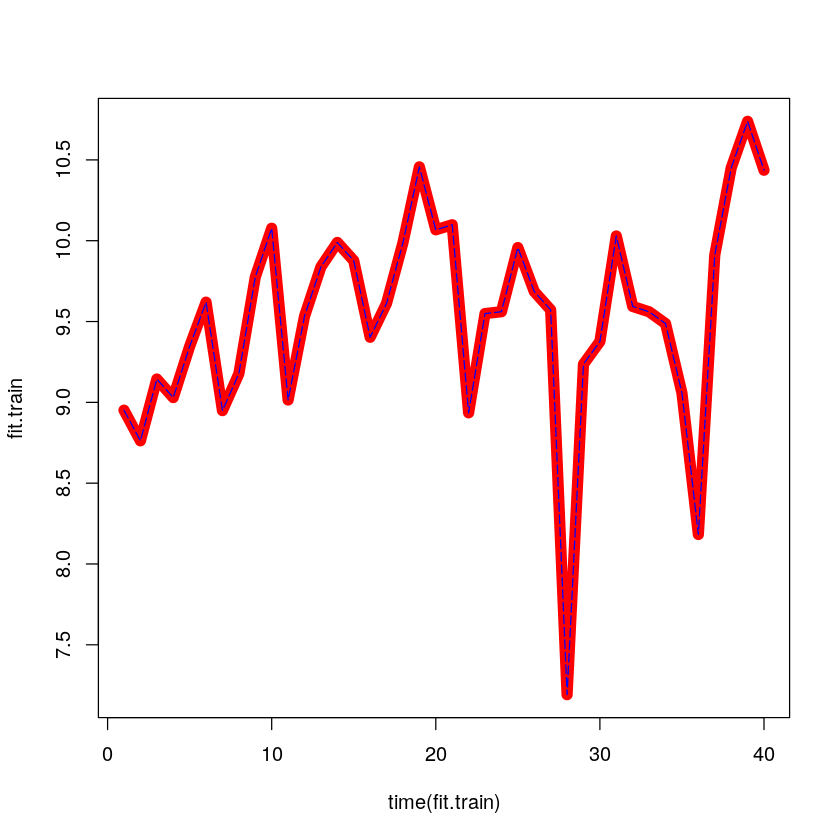

In [32]:
plot(time(fit.train),fit.train,type="l",col="red",lwd=9)
points(time(fit.train),W,type="l",col="blue",lty=5)

In [33]:
D=sqrt(var(Y_pred))*1.96
D

[1] 0.2627436

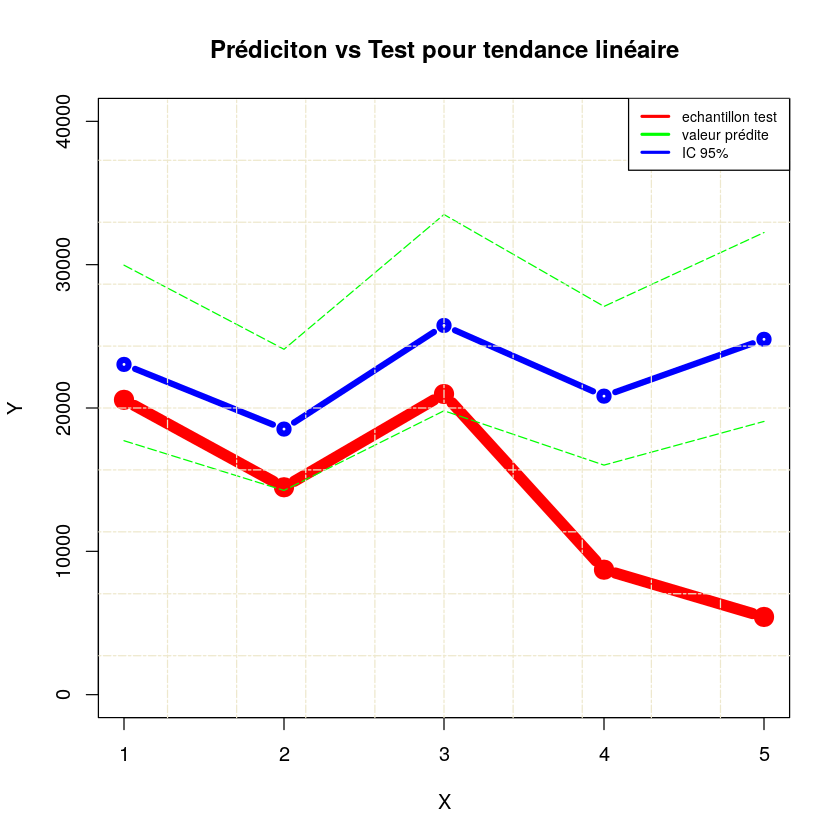

In [34]:
plot(time(fit.test),exp(fit.test),type="b",col="red",lwd=9,ylim=c(0,40000),main="Prédiciton vs Test pour tendance linéaire",ylab="Y",xlab="X")
points(time(fit.test),exp(Y_pred),type="b",col="blue",lwd=5)
points(time(fit.test),exp(Y_pred+D),type="l",col="green",lty=5)
points(time(fit.test),exp(Y_pred-D),type="l",col="green",lty=5)
grid (10,10, lty = 6, col = "cornsilk2")
legend("topright",c("echantillon test","valeur prédite","IC 95%"),col=c("red","green","blue"),lty=c(1,1),lwd=c(2.5,2.5),cex=0.7)

## Partie ave la fonciton quadratiques:

Comme déjà le coefficient de la tendance linéaire n'est pas singificatif mais aussi que la prédiction n'est pas assez bonne, on va alors modéliser à partir d'une tendance quadratique dans cette partie.

In [35]:
t1=time(fit.train)
t2=time(fit.train)^2
lm.res1<-lm(X_mod~t1+t2)
summary(lm.res1)


Call:
lm(formula = X_mod ~ t1 + t2)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.45417 -0.25971 -0.00929  0.37533  1.06509 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.1890168  0.3229502  28.453   <2e-16 ***
t1           0.0261907  0.0363274   0.721    0.475    
t2          -0.0003530  0.0008593  -0.411    0.684    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6471 on 37 degrees of freedom
Multiple R-squared:  0.04925,	Adjusted R-squared:  -0.002144 
F-statistic: 0.9583 on 2 and 37 DF,  p-value: 0.3929


In [36]:
Equa1=lm.res1$coefficients[1]+lm.res1$coefficients[2]*t1+lm.res1$coefficients[3]*t2
extract1=fit.train-Equa1

[1] 36

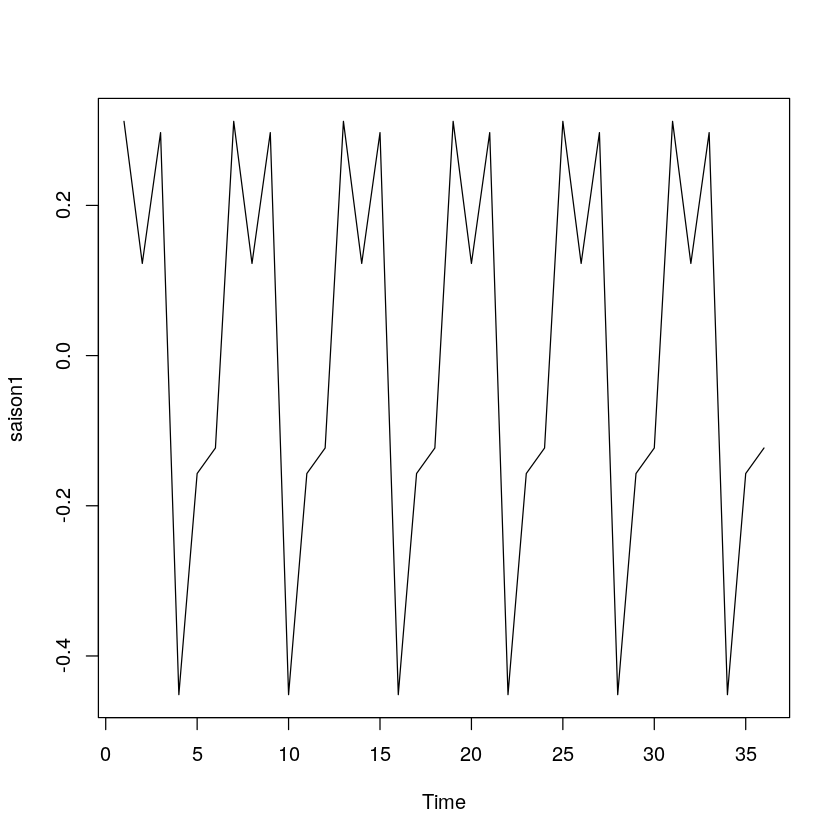

In [37]:
saison1=saison2_fontion(extract1,T=length(fit.train),d=floorD)
ts.plot(saison1)
length(saison1)

## Estimation du bruit selon une tendance quadratique

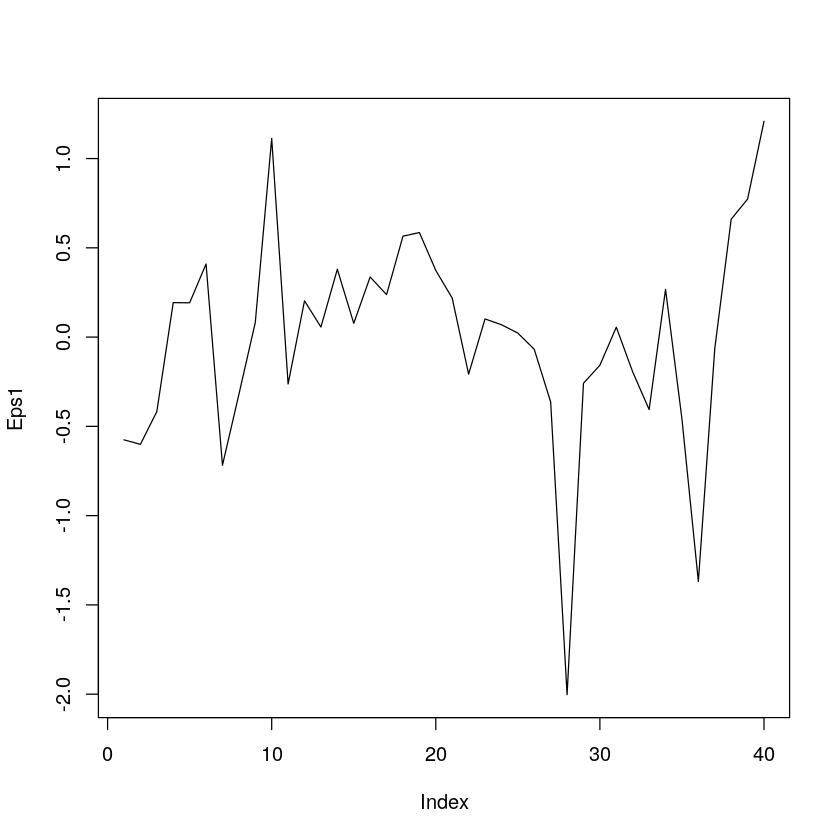

In [38]:
a_h1=lm.res1$coefficients[1]
b_h1=lm.res1$coefficients[2]
c_h1=lm.res1$coefficients[3]
res_tend1=lm.res1$residuals
U1=c_h1*t2+b_h1*t1+a_h1
Eps1=fit.train-(U1+c(saison1,saison[1:4]))
plot(Eps1,type="l")

## Modélisation des Epsilon:

In [39]:
pp.test(Eps1)
arma1=auto.arima(Eps1)
arma1


	Phillips-Perron Unit Root Test

data:  Eps1
Dickey-Fuller Z(alpha) = -22.843, Truncation lag parameter = 3, p-value
= 0.01726
alternative hypothesis: stationary


Series: Eps1 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.3696
s.e.  0.1559

sigma^2 estimated as 0.3008:  log likelihood=-32.3
AIC=68.6   AICc=68.93   BIC=71.98

## Corrélation ou non des résidus:


In [40]:
Box.test(arma1$residuals)


	Box-Pierce test

data:  arma1$residuals
X-squared = 0.015798, df = 1, p-value = 0.9


On a bien des bruits indépendant.

## Prédiction

In [41]:
forcast1=forecast(arma1,h=5)

In [42]:
h1=41:45
h2=h1^2
tend1=c_h1*h2+b_h1*h1+a_h
Y_pred1=tend1+saison1[1:5]+forcast1$mean
mean((exp(Y_pred1)-exp(fit.test))^2)

[1] 94251027

In [43]:
D1=sqrt(var(Y_pred1))*1.96
D1

[1] 0.9175571

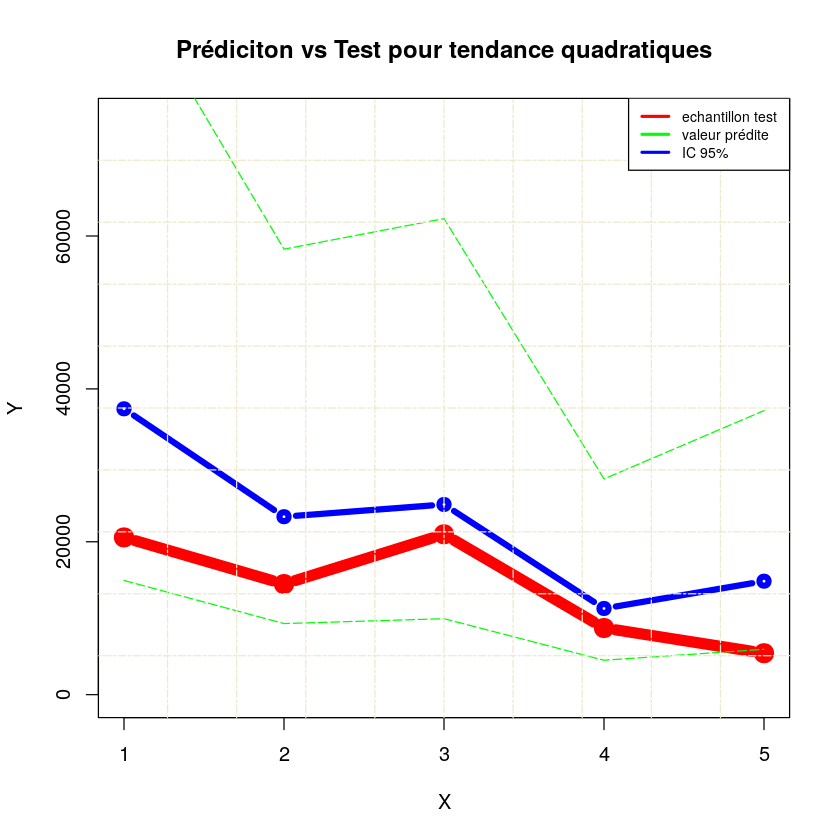

In [44]:
plot(time(fit.test),exp(fit.test),type="b",col="red",lwd=9,ylim=c(0,75000),main="Prédiciton vs Test pour tendance quadratiques",ylab="Y",xlab="X")
points(time(fit.test),exp(Y_pred1),type="b",col="blue",lwd=5)
points(time(fit.test),exp(Y_pred1+D1),type="l",col="green",lty=5)
points(time(fit.test),exp(Y_pred1-D1),type="l",col="green",lty=5)
grid (10,10, lty = 6, col = "cornsilk2")
legend("topright",c("echantillon test","valeur prédite","IC 95%"),col=c("red","green","blue"),lty=c(1,1),lwd=c(2.5,2.5),cex=0.7)

[1] 22

[1] 22

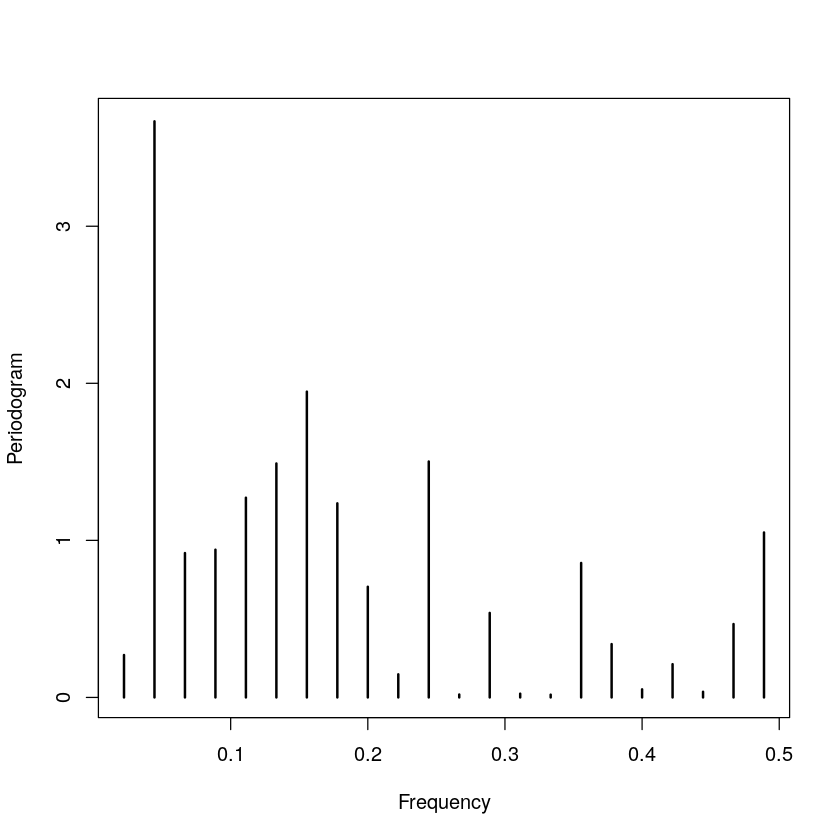

In [45]:
per=periodogram(Y)
floorD=floor(length(Y)/which.max(per$spec));floorD
floorD

# Projection vs ChainLadder
## Estimation de la tendance de la série complète
Utilisation du modèle quadratique.

[1] 22


Call:
lm(formula = Y ~ t1 + t2)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.46684 -0.22363  0.02828  0.38060  1.18157 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.1023491  0.2961099  30.740   <2e-16 ***
t1           0.0407144  0.0296925   1.371    0.178    
t2          -0.0007450  0.0006259  -1.190    0.241    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6329 on 42 degrees of freedom
Multiple R-squared:  0.04986,	Adjusted R-squared:  0.004611 
F-statistic: 1.102 on 2 and 42 DF,  p-value: 0.3417


[1] 45

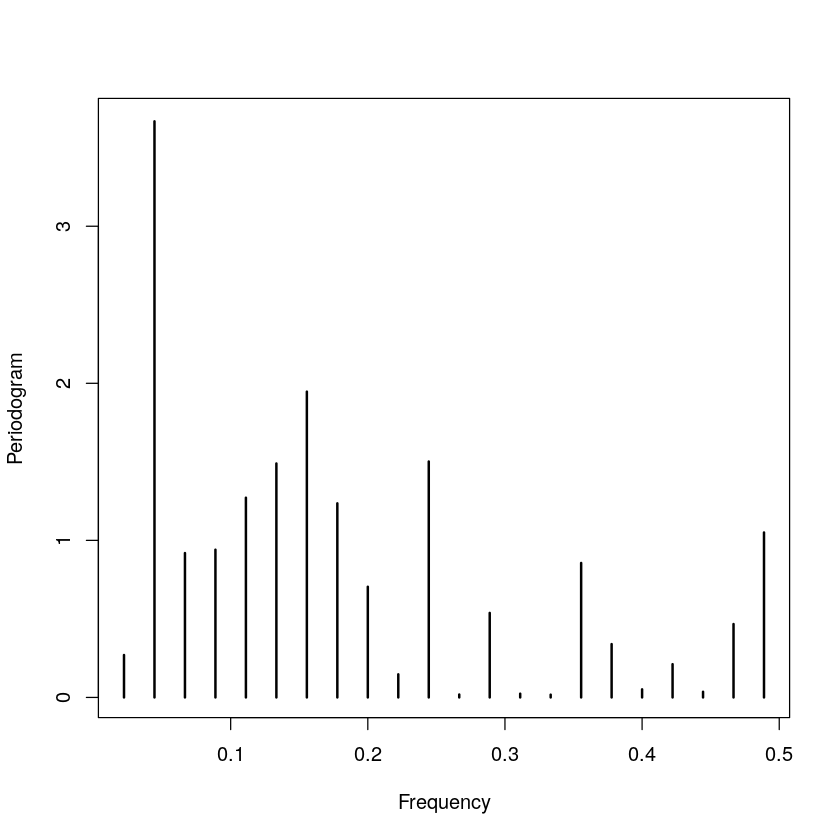

In [46]:
per=periodogram(Y)
floorD=floor(length(Y)/which.max(per$spec));floorD
t1=time(Y)
t2=t1^2
lmres=lm(Y~t1+t2)
summary(lmres)
length(Y)

## Estimation de la saisonnalité

In [47]:
Equa=lmres$coefficients[1]+lmres$coefficients[2]*t1+lmres$coefficients[3]*t2
extract=Y-Equa

[1] 44

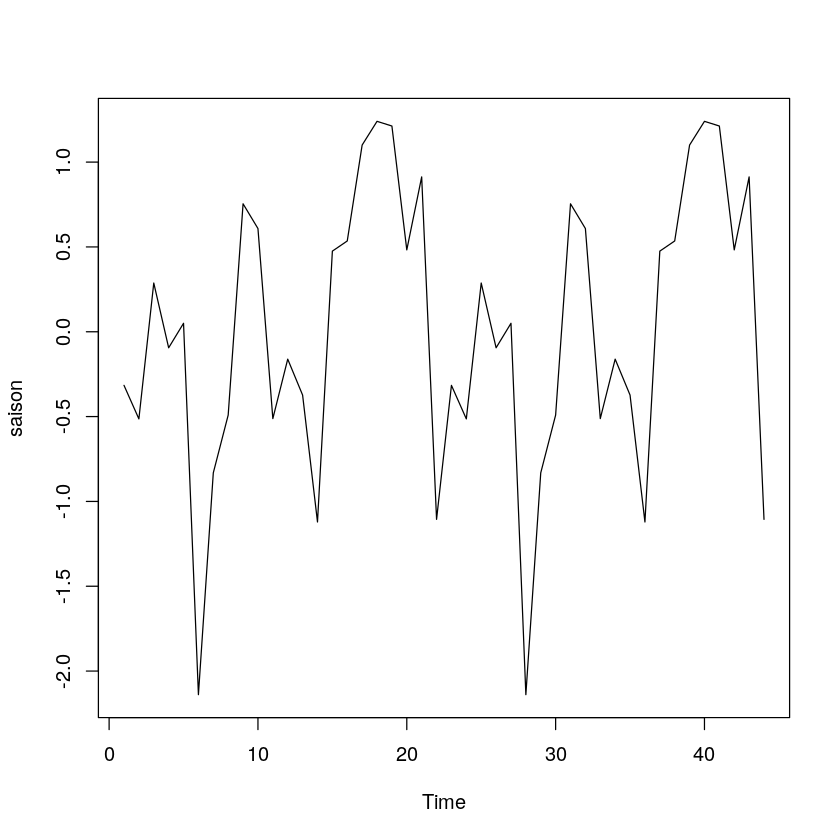

In [48]:
saison=saison2_fontion(extract,T=length(Y),d=floorD)
ts.plot(saison)
length(saison)

### Moélisation des bruits:

In [49]:
a_h=lmres$coefficients[1]
b_h=lmres$coefficients[2]
c_h=lmres$coefficients[3]
res_tend=lmres$residuals
U=a_h+ b_h*t1+ c_h*t2

Eps=Y-(U+c(saison,saison[1]))

## Modélisation des bruits:

In [50]:
pp.test(Eps)#with unit root
kpss.test(Eps)
adf.test(Eps)
arma=auto.arima(Eps)
arma
Box.test(arma$residuals)

Warning message in pp.test(Eps):
“p-value smaller than printed p-value”


	Phillips-Perron Unit Root Test

data:  Eps
Dickey-Fuller Z(alpha) = -30.317, Truncation lag parameter = 3, p-value
= 0.01
alternative hypothesis: stationary


Warning message in kpss.test(Eps):
“p-value greater than printed p-value”


	KPSS Test for Level Stationarity

data:  Eps
KPSS Level = 0.25013, Truncation lag parameter = 1, p-value = 0.1



	Augmented Dickey-Fuller Test

data:  Eps
Dickey-Fuller = -3.9624, Lag order = 3, p-value = 0.01986
alternative hypothesis: stationary


Series: Eps 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.3548:  log likelihood=-40.54
AIC=83.07   AICc=83.17   BIC=84.88


	Box-Pierce test

data:  arma$residuals
X-squared = 3.1541, df = 1, p-value = 0.07574


In [51]:
forcast=forecast(arma,h=72)

## Remplissons maintenant le tableau de paiement:

In [52]:
th= seq(46:117)
th2= th^2
csaison=c(saison[2:44],saison[1:29])
trend= a_h+ b_h*th+ c_h*th2
Y_complet= round( exp(c(Y,trend+ csaison+ forcast$mean)),0 )

### Construction du tableau de triangle de paiement

Fonction qui permet de sonstruire la matrice de paiement complète grace à Y.

In [53]:
M_serie<-function(Y,n,date=1987){
  M=matrix(nrow=n,ncol=n)
  r=n
  for(j in 1:r){
       I=((j-1)*j/2+1):((j-1)*(j+2)/2+1)
       tj=(j-1)*j/2+1
       for(t in I){
           M[abs(tj+j-t),abs(t-tj+1)]=Y[t]
       }
   }
    
 for(k in 1:(n-1)){
     for(t in k:(n-1)){
         j=t+1
         i=n+k-t
         M[i,j]=Y[(n+1)*n/2+j+(k-1)*n]
     }
 } 
    rownames(M)<-1:n+date
    colnames(M)<-0:(n-1)
    return(M)
}

### Paiements non cumulé et cumulé

In [54]:
M_final=M_serie(Y_complet,9)

In [55]:
M_cm=M_final
for(i in 1:(ncol(M_final)-1)){
    M_cm[,i+1]=M_cm[,i+1]+M_cm[,i]
}
print("Non cumulé:modèle à tendance quadratique")
round(M_final,0)
print("Cumulé:modèle à tendance quadratique")
round(M_cm,0)

[1] "Non cumulé:modèle à tendance quadratique"


,0,1,2,3,4,5,6,7,8
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423
1989,6387,11455,17587,21793,23569,14359,8581,8719,22400
1990,8347,9675,18736,34779,16084,13192,20976,25200,49339
1991,7700,13802,21770,21111,14189,14470,7044,49987,1844
1992,8223,14958,14195,14665,20570,4857,42771,16437,23809
1993,12122,14034,22678,34075,1272,23877,14187,4883,7422
1994,7596,11808,46103,10974,22062,20695,10427,9279,5523
1995,10264,34552,9167,4378,9238,13006,4315,17604,9829
1996,20162,12940,9049,11176,9232,33220,21147,21493,1541


[1] "Cumulé:modèle à tendance quadratique"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,134850
1990,8347,18022,36758,71537,87621,100813,121789,146989,196328
1991,7700,21502,43272,64383,78572,93042,100086,150073,151917
1992,8223,23181,37376,52041,72611,77468,120239,136676,160485
1993,12122,26156,48834,82909,84181,108058,122245,127128,134550
1994,7596,19404,65507,76481,98543,119238,129665,138944,144467
1995,10264,44816,53983,58361,67599,80605,84920,102524,112353
1996,20162,33102,42151,53327,62559,95779,116926,138419,139960


## ChainLadder
On va créer une fonction qui estime ChainLadder.

In [56]:
Chain_LD<-function(PAID,n,date=1987){
 nc=ncol(PAID)
 nl=nrow(PAID)
 lambda<-rep(NA,nc-1)
 for(k in 1:(nc-1)){
    lambda[k]=(sum(PAID[1:(nl-k),k+1])/sum(PAID[1:(nl-k),k]))
 }
  triangle <- PAID
  for(i in 1:(nc-1)){
    triangle[(nl-i+1):(nl),i+1]=lambda[i]*triangle[(nl-i+1):(nl),i]
  }
 colnames(triangle)<-0:(n-1)
  rownames(triangle)<-0:(n-1)+date+1
  Non_cum_paid=triangle
  Non_cum_paid[,2:nc]=-Non_cum_paid[,1:(nc-1)]+Non_cum_paid[,2:nc]
    
 return (list(Lambda=lambda,Resultat_CHainLadder=triangle,Non_cum_res=Non_cum_paid)) 
}

In [57]:
PAID=Mat_tri(Clear_repar_data(data$CumPaidLoss),r=9)
Res_paid_loss=Chain_LD(PAID,n=9)
Res_paid_loss$Lambda
print("Prevision ChainLadder non cumulé")
round(Res_paid_loss$Non_cum_res)
print("Prevision ChainLadder  cumulé")
round(Res_paid_loss$Resultat_CHainLadder)

[1] 2.750256 2.090386 1.642474 1.311783 1.205755 1.104456 1.060053 1.051837

[1] "Prevision ChainLadder non cumulé"


,0,1,2,3,4,5,6,7,8
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423
1989,6387,11455,17587,21793,23569,14359,8581,8719,5829
1990,8347,9675,18736,34779,16084,13192,20976,7314,6692
1991,7700,13802,21770,21111,14189,14470,9719,6171,5647
1992,8223,14958,14195,14665,20570,14940,9145,5807,5313
1993,12122,14034,22678,34075,25850,22378,13698,8698,7959
1994,7596,11808,46103,42087,33546,29040,17776,11287,10328
1995,10264,34552,48867,60189,47975,41531,25422,16142,14770
1996,20162,35289,60463,74471,59359,51386,31455,19973,18275


[1] "Prevision ChainLadder  cumulé"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,118279
1990,8347,18022,36758,71537,87621,100813,121789,129103,135795
1991,7700,21502,43272,64383,78572,93042,102761,108932,114579
1992,8223,23181,37376,52041,72611,87551,96696,102503,107817
1993,12122,26156,48834,82909,108759,131136,144834,153532,161491
1994,7596,19404,65507,107594,141139,170180,187956,199243,209571
1995,10264,44816,93683,153871,201846,243377,268799,284941,299712
1996,20162,55451,115913,190385,249743,301129,332584,352557,370832


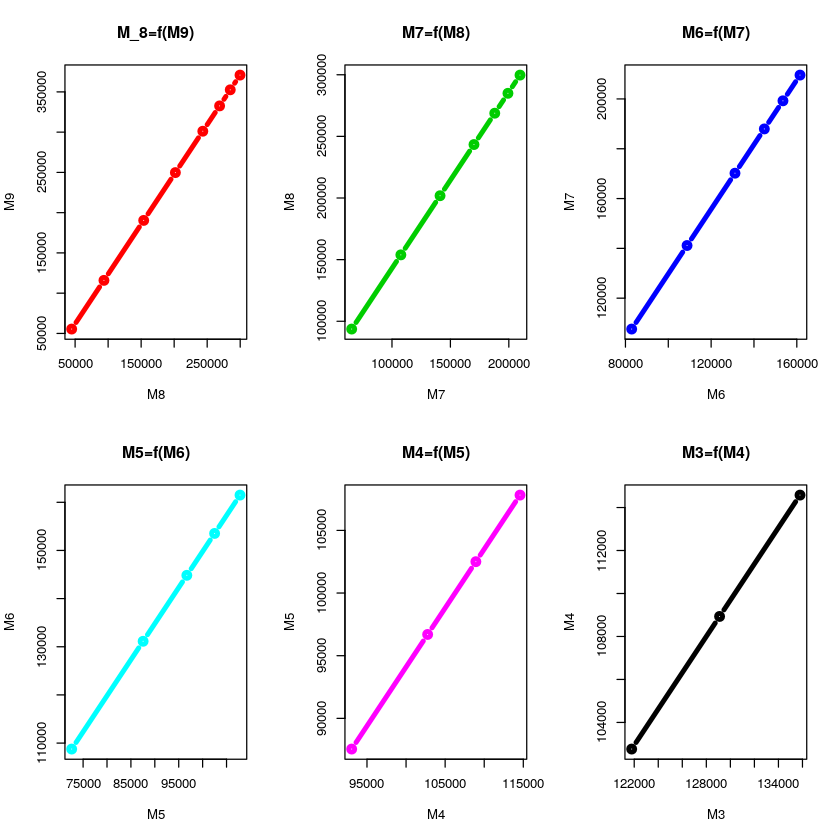

In [58]:
par(mfrow=c(2,3))
plot(Res_paid_loss$Resultat_CHainLadder[8,2:9],Res_paid_loss$Resultat_CHainLadder[9,2:9],type="b",
    main="M_8=f(M9)",xlab="M8",ylab="M9",col=2,lwd=4)
plot(Res_paid_loss$Resultat_CHainLadder[7,3:9],Res_paid_loss$Resultat_CHainLadder[8,3:9],type="b",
    main="M7=f(M8)",xlab="M7",ylab="M8",col=3,lwd=4)
plot(Res_paid_loss$Resultat_CHainLadder[6,4:9],Res_paid_loss$Resultat_CHainLadder[7,4:9],type="b",
    main="M6=f(M7)",xlab="M6",ylab="M7",col=4,lwd=4)
plot(Res_paid_loss$Resultat_CHainLadder[5,5:9],Res_paid_loss$Resultat_CHainLadder[6,5:9],type="b",
    main="M5=f(M6)",xlab="M5",ylab="M6",col=5,lwd=4)
plot(Res_paid_loss$Resultat_CHainLadder[4,6:9],Res_paid_loss$Resultat_CHainLadder[5,6:9],type="b",
    main="M4=f(M5)",xlab="M4",ylab="M5",col=6,lwd=4)
plot(Res_paid_loss$Resultat_CHainLadder[3,7:9],Res_paid_loss$Resultat_CHainLadder[4,7:9],type="b",
    main="M3=f(M4)",xlab="M3",ylab="M4",col=9,lwd=4)
#plot(Res_paid_loss$Resultat_CHainLadder[3,8:10],Res_paid_loss$Resultat_CHainLadder[4,8:10],type="b",
 #   main="M3=f(M4)",xlab="M3",ylab="M4",col=9,lwd=4)


ChainLadder à l'air d'être correcte vu que les $(C_{i,j},C_{i,j+1})$ semblent bien êtres alignés.

## Comparaison avec les valeurs réelles :
Dans cette partie, on va comparer les résultats obtenue par ChainLadder et les projections
avec la réalité (les valeurs réelles).

In [59]:
M=matrix(nrow=9,ncol=9)
rownames(M)<-1988:1996
colnames(M)<-0:8
for(i in 0:8){
    for(j in 0:8){
        M[i+1,j+1]=Clear_repar_data(data$CumPaidLoss)[i*9+j+1]
    }
}

In [99]:
print("Paiement cumulé réel")
M
print("Projection (modèle additif)")
M_cm
print("ChainLadder")
floor(Res_paid_loss$Resultat_CHainLadder)

[1] "Paiement cumulé réel"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,113114
1990,8347,18022,36758,71537,87621,100813,121789,122055,128573
1991,7700,21502,43272,64383,78572,93042,100276,114385,118308
1992,8223,23181,37376,52041,72611,76059,87673,90548,93678
1993,12122,26156,48834,82909,94462,106848,110922,114891,126605
1994,7596,19404,65507,111264,132097,145771,152482,158610,163183
1995,10264,44816,62018,90376,124206,136217,145287,151645,157738
1996,20162,28107,51626,87054,106951,123071,131318,141446,145749


[1] "Projection (modèle additif)"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,134850
1990,8347,18022,36758,71537,87621,100813,121789,146989,196328
1991,7700,21502,43272,64383,78572,93042,100086,150073,151917
1992,8223,23181,37376,52041,72611,77468,120239,136676,160485
1993,12122,26156,48834,82909,84181,108058,122245,127128,134550
1994,7596,19404,65507,76481,98543,119238,129665,138944,144467
1995,10264,44816,53983,58361,67599,80605,84920,102524,112353
1996,20162,33102,42151,53327,62559,95779,116926,138419,139960


[1] "ChainLadder"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,118279
1990,8347,18022,36758,71537,87621,100813,121789,129102,135795
1991,7700,21502,43272,64383,78572,93042,102760,108931,114578
1992,8223,23181,37376,52041,72611,87551,96696,102503,107816
1993,12122,26156,48834,82909,108758,131136,144834,153531,161490
1994,7596,19404,65507,107593,141139,170179,187955,199243,209571
1995,10264,44816,93682,153871,201846,243376,268799,284941,299711
1996,20162,55450,115913,190384,249743,301129,332584,352556,370831


## Modèle à tendance linéaire:

In [60]:
t1=1:length(Y)
lmreg=lm(Y~t1)
summary(lmreg)


Call:
lm(formula = Y ~ t1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.35981 -0.32129  0.03022  0.40917  1.11651 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.370798   0.192815  48.600   <2e-16 ***
t1          0.006444   0.007300   0.883    0.382    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.636 on 43 degrees of freedom
Multiple R-squared:  0.0178,	Adjusted R-squared:  -0.00504 
F-statistic: 0.7793 on 1 and 43 DF,  p-value: 0.3823


In [61]:
a=lmreg$coefficients[1]
b=lmreg$coefficients[2]
Equation=a+b*t1

## Estimation de la saisonnalité:

In [62]:
diff=Y-Equation
season=saison2_fontion(Equation,T =length(Y),d = floorD)
floorD

[1] 22

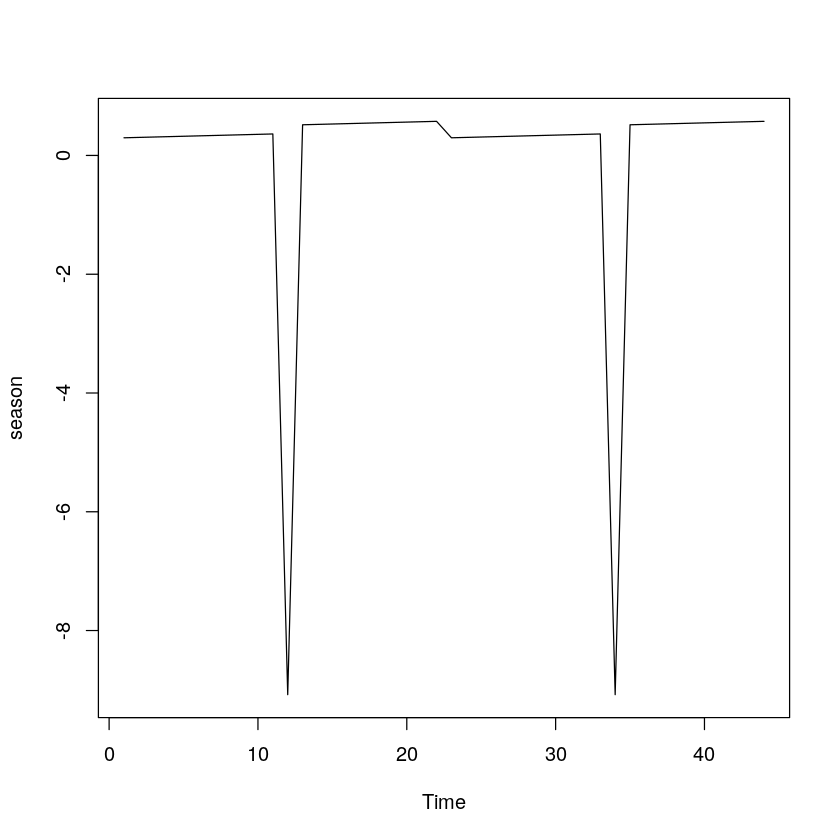

In [63]:
ts.plot(season)

## Estimation des Bruits:

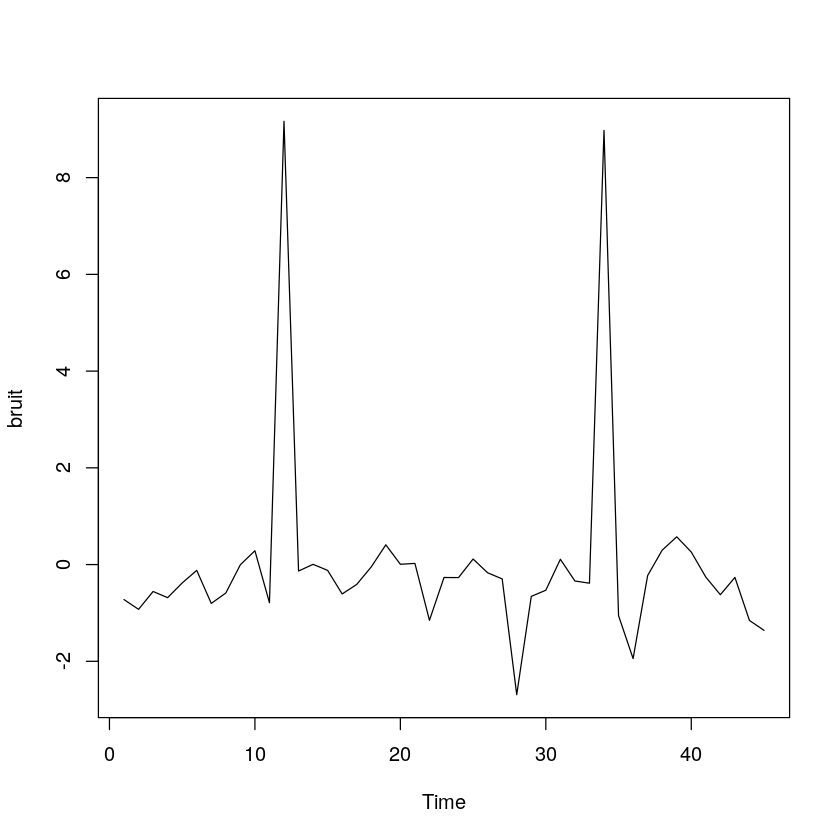

In [64]:
bruit=Y-(Equation+c(season,season[1]))
ts.plot(bruit)

## Stationnarité des bruits:

In [65]:
pp.test(bruit)
kpss.test(bruit)

Warning message in pp.test(bruit):
“p-value smaller than printed p-value”


	Phillips-Perron Unit Root Test

data:  bruit
Dickey-Fuller Z(alpha) = -44.35, Truncation lag parameter = 3, p-value
= 0.01
alternative hypothesis: stationary


Warning message in kpss.test(bruit):
“p-value greater than printed p-value”


	KPSS Test for Level Stationarity

data:  bruit
KPSS Level = 0.05524, Truncation lag parameter = 1, p-value = 0.1


Nos bruits sont bien stationnaires.

## Modélisation des bruits

In [66]:
arma=auto.arima(bruit)
arma

Series: bruit 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 4.184:  log likelihood=-96.06
AIC=194.11   AICc=194.21   BIC=195.92

##   Test de corrélation des brtuis

In [67]:
Box.test(arma$residuals)


	Box-Pierce test

data:  arma$residuals
X-squared = 0.14407, df = 1, p-value = 0.7043


Nos bruits sont significatif.

## Prediction

In [68]:
b_pred=forecast(arma,h=72)


In [69]:

tf=46:117
Eq=a+b*tf
length(season[2:44])
dseason=rep(c(season[2:44],season[1:29]))
Y_predict=Eq+dseason+b_pred$mean
Y_fin=exp(c(Y,Y_predict))

[1] 43

In [105]:
M_fin=M_serie(Y_fin,9)
M_cm1=M_fin
for(i in 1:(ncol(M_fin)-1)){
    M_cm1[,i+1]=M_cm1[,i+1]+M_cm1[,i]
}
print("Non cumulé:modèle à tendance linéaire")

round(M_fin,0)
print("Cumulé: modèle à tendance linéaire")
round(M_cm1,0)

[1] "Non cumulé:modèle à tendance linéaire"


,0,1,2,3,4,5,6,7,8
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423
1989,6387,11455,17587,21793,23569,14359,8581,8719,23722
1990,8347,9675,18736,34779,16084,13192,20976,23418,30697
1991,7700,13802,21770,21111,14189,14470,23118,30304,25961
1992,8223,14958,14195,14665,20570,22822,29916,25629,33595
1993,12122,14034,22678,34075,22530,29533,25301,33165,28413
1994,7596,11808,46103,22241,29154,24977,32740,28049,31907
1995,10264,34552,21956,28781,24657,2,36767,31499,41289
1996,20162,21675,28413,24341,27689,36296,31095,40761,34920


[1] "Cumulé: modèle à tendance linéaire"


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,136172
1990,8347,18022,36758,71537,87621,100813,121789,145207,175904
1991,7700,21502,43272,64383,78572,93042,116160,146464,172425
1992,8223,23181,37376,52041,72611,95433,125349,150978,184573
1993,12122,26156,48834,82909,105439,134971,160272,193437,221850
1994,7596,19404,65507,87748,116903,141879,174620,202668,234575
1995,10264,44816,66772,95553,120210,120213,156980,188478,229767
1996,20162,41837,70250,94591,122280,158577,189672,230432,265352


# Projection différenciés et désaisonnalisé:

In [106]:
Z_t<-function(fit,L=90,r=10){
    Z=c()
    temp=0
    for(i in 1:L){
        if(i<=r+1){
            Z=c(Z,0)
        }else{
            temp=fit[i]-fit[i-r]-fit[i-1]+fit[i-r-1]
            Z=c(Z,temp)
        }
    }
    return(Z)
}

Time Series:
Start = 1 
End = 40 
Frequency = 1 
 [1]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
 [7]  0.00000000  0.41774506  0.21543414  0.41673249 -1.37893841  0.24432890
[13]  0.97638879 -0.07718290 -0.71032875 -0.77604223  1.27263857 -0.14259180
[19]  0.16284758 -0.54022348  0.14371063 -0.68945429  0.40363687 -0.36387977
[25] -0.07157644  0.11711222 -0.14444470 -1.21739574  1.43110741  0.12872781
[31]  0.25571358 -0.16396235  0.08045138  2.30784644 -2.47502870 -1.01488111
[37]  1.07637764  0.97459738  0.32140927 -0.22945761

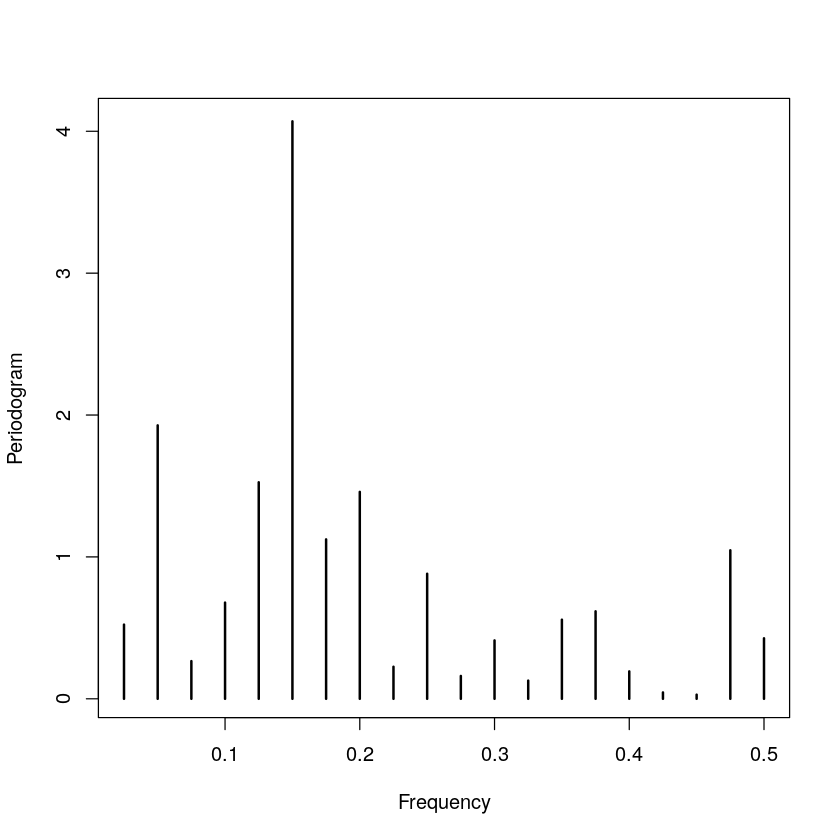

In [107]:
floorD=floor(length(fit.train)/which.max(periodogram(fit.train)$spec))
Z<-Z_t(fit.train,L=40,r=floorD)
(ts(Z))

## Stationnarité:


In [108]:

pp.test(Z)
kpss.test(Z)

Warning message in pp.test(Z):
“p-value smaller than printed p-value”


	Phillips-Perron Unit Root Test

data:  Z
Dickey-Fuller Z(alpha) = -36.215, Truncation lag parameter = 3, p-value
= 0.01
alternative hypothesis: stationary


Warning message in kpss.test(Z):
“p-value greater than printed p-value”


	KPSS Test for Level Stationarity

data:  Z
KPSS Level = 0.034976, Truncation lag parameter = 1, p-value = 0.1


On a des bruits qui sont stationnaires

## Modélisation de Z en ARMA:

In [109]:
arma<-auto.arima(ts(Z))
summary(arma)
arma$residuals

Series: ts(Z) 
ARIMA(0,0,1) with zero mean 

Coefficients:
          ma1
      -0.7573
s.e.   0.1429

sigma^2 estimated as 0.494:  log likelihood=-42.57
AIC=89.14   AICc=89.47   BIC=92.52

Training set error measures:
                     ME      RMSE       MAE      MPE     MAPE     MASE
Training set 0.05363929 0.6939848 0.4889009 70.41454 166.1191 0.577794
                  ACF1
Training set 0.1516016


Time Series:
Start = 1 
End = 40 
Frequency = 1 
 [1]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
 [7]  0.00000000  0.41669409  0.52944214  0.81643235 -0.76080053 -0.33146749
[13]  0.72532242  0.47197999 -0.35290996 -1.04325844  0.48258928  0.22286696
[19]  0.33162228 -0.28908491 -0.07521384 -0.74641319 -0.16162450 -0.48627849
[25] -0.43983710 -0.21597830 -0.30800599 -1.45064999  0.33252370  0.38054949
[31]  0.54390541  0.24793965  0.26821719  2.51096852 -0.57346099 -1.44916569
[37] -0.02108204  0.95863186  1.04738548  0.56373210

## Test si on a des résidus corrélés ou non:

In [110]:
Box.test(arma$residuals,type=c("Ljung-Box"))


	Box-Ljung test

data:  arma$residuals
X-squared = 0.99004, df = 1, p-value = 0.3197


p-value>$5\%$ donc on a des résidus bien décorrélés.

## Prédiction

In [111]:
Prediction<-function(X,T,t,r=10,arma_mod){
    if(T>=t){
        return(X[t])
    }
    X_r=0
    temp=forecast(arma_mod,h=t-T)
    Z=sum(c(temp$mean,arma_mod$x[(r+2):T]))
    cste=X[11]-X[1]
    if(t-r>T){
        return(Z+cste+Prediction(X,T,t-r,r,arma_mod))
    }else{
         return(Z+cste+X[t-r])
    }
}

In [112]:
Val_pred<-function(X=fit.train,T1=length(fit.train),h=length(fit.test),r_k=10,arma_m=arma){
    res=c()
    for(i in 1:h){
        res=c(res,Prediction(X,T=T1,t=i+T,r=r_k,arma_mod=arma_m))
    }
    return(res)
}

In [113]:
floorD
pred=Val_pred(r=floorD)
pred

[1] 6

[1] 8.762020 9.144201 9.029657 9.346182 9.619731

In [114]:
MSE=mean((exp(pred)-exp(fit.test))^2)
akaik=arma$aic
bic=BIC(arma)
Ljung_Box=0.3536
p_q="(0,0)"
table<-cbind(p_q,Ljung_Box,akaik,bic,MSE)
table
fit.test

p_q,Ljung_Box,akaik,bic,MSE
"(0,0)",0.3536,89.1428271593394,92.5205860675673,97419884.4000001


[1] 9.931589 9.579833 9.951134 9.073260 8.598404

In [115]:
delta=sqrt(var(pred))*1.96

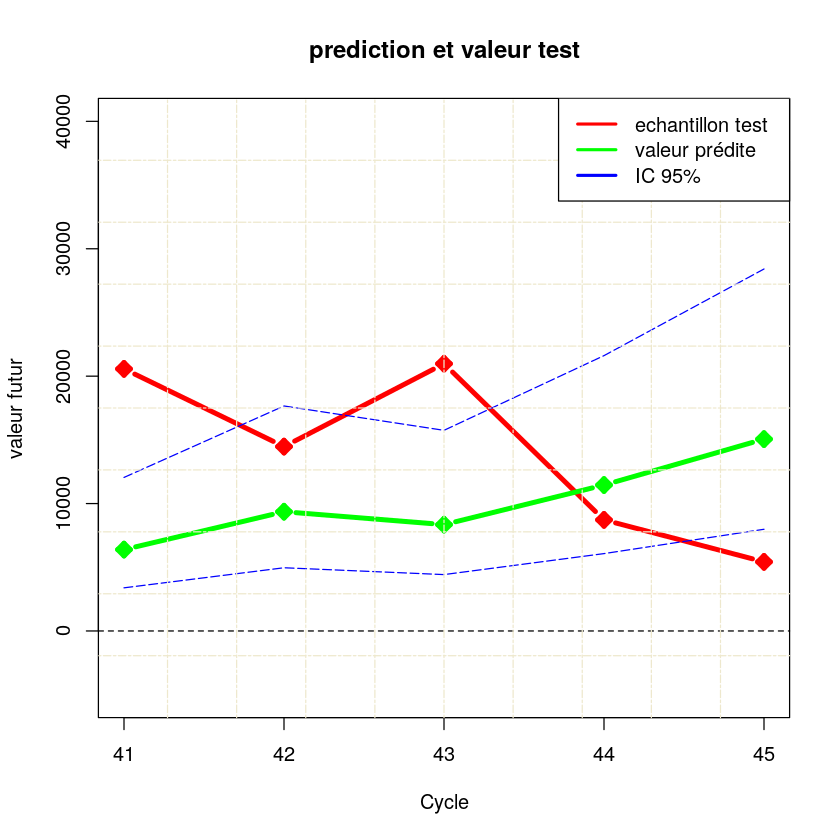

In [116]:
plot(time(fit.test)+length(fit.train),exp(fit.test),type="b",
     col="red",main="prediction et valeur test",pch=9,lwd=4,ylim=c(-5000,40000),xlab="Cycle",ylab="valeur futur")
points(time(fit.test)+length(fit.train),exp(pred),type="b",lwd=4,pch=9,col="green")
points(time(fit.test)+length(fit.train),exp(pred+delta),type="l",lty=5,col="blue")
points(time(fit.test)+length(fit.train),exp(pred-delta),type="l",lty=5,col="blue")
abline(h=0,lty=8)
abline(v=90,lty=1,pch=9)
grid (10,10, lty = 6, col = "cornsilk2")
legend("topright",c("echantillon test","valeur prédite","IC 95%"),col=c("red","green","blue"),lty=c(1,1),lwd=c(2.5,2.5))

## Remarque:
Comme la périodicité de notre série change selon la taille de l'échantillon que l'on étudie, donc on ne peut pas être sûr que la modélisation avec échantillon d'apprentissage et échantillon testé est fiable. Donc pour faire le provisionnement avec le triangle de paiement, on va utiliser toutes nons données. 

## Prédiction avec le triange de paiement:
Dans cette partie, on va considérer toute la série temporelle toute entière.

[1]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
 [7]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[13]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[19]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.20082698
[25]  0.01472383 -0.15742614 -0.42997219 -2.65425238  2.71572407 -0.08819027
[31]  0.05500327 -0.73812099  1.02941760 -0.59073483 -0.73569343 -1.02588848
[37]  1.84170966  1.01251863  0.07818830 -0.67760065 -0.97321116  0.03732530
[43]  0.34030475  0.28543276 -1.08871655

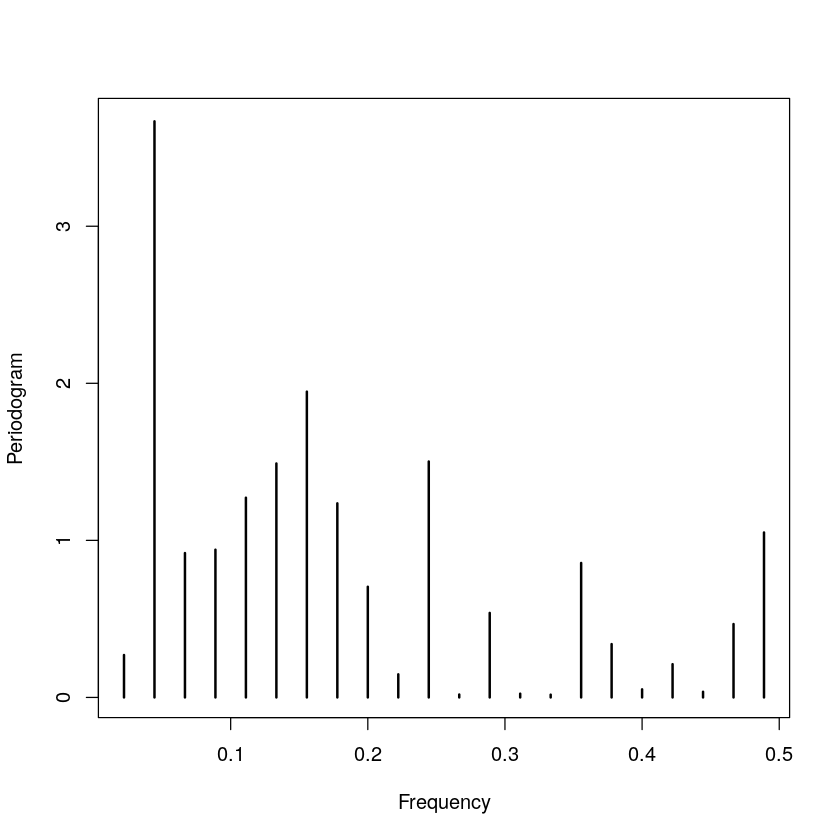

In [135]:
floorD=floor(length(Y)/which.max(periodogram(Y)$spec))
Z_reel<-Z_t(Y,L=45,r=floorD)
Z_reel

## Test de stationnarité:

In [134]:
p=pp.test(Z_reel)
p$p.value

Warning message in pp.test(Z_reel):
“p-value smaller than printed p-value”

[1] TRUE

## Modélisation en ARIMA

In [119]:
arma_r<-auto.arima(Z_reel)
arma_r

Series: Z_reel 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.5654:  log likelihood=-51.02
AIC=104.04   AICc=104.14   BIC=105.85

## Test sur les résidus

In [130]:
a=Box.test(arma_r$residuals)
a$p.value

[1] 0.1096038

## Prédiction:

In [136]:
pred=Val_pred(X=Y,T1 = length(Y),r_k=floorD,h=90,arma_m = arma_r)

In [137]:
Y_k=c(Y,pred)

### tableau de paiement

In [138]:
M_final=M_serie(exp(Y_k),9)
print("non cumulé:Methode de la différenciés et désaisonnalisé: ")
round(M_final,0)

[1] "non cumulé:Methode de la différenciés et désaisonnalisé: "


,0,1,2,3,4,5,6,7,8
1988,7719,9360,15059,23792,19470,24311,1328,3578,5423
1989,6387,11455,17587,21793,23569,14359,8581,8719,23792
1990,8347,9675,18736,34779,16084,13192,20976,17587,34779
1991,7700,13802,21770,21111,14189,14470,9675,21770,1328
1992,8223,14958,14195,14665,20570,7700,14958,14359,20162
1993,12122,14034,22678,34075,15059,12122,16084,3578,3214
1994,7596,11808,46103,11455,19470,21111,8581,5423,3213
1995,10264,34552,8347,21793,14195,13192,8719,3320,3276
1996,20162,9360,18736,14034,14189,20976,5135,4657,526


In [139]:
M_Pr=M_final
for(i in 1:(ncol(M_Pr)-1)){
    M_Pr[,i+1]=M_Pr[,i+1]+M_Pr[,i]
}
print("cumulé:Methode de la différenciés et désaisonnalisé: ")
floor(M_Pr)

[1] "cumulé:Methode de la différenciés et désaisonnalisé: "


,0,1,2,3,4,5,6,7,8
1988,7719,17079,32138,55930,75400,99711,101039,104617,110040
1989,6387,17842,35429,57222,80791,95150,103731,112450,136242
1990,8346,18022,36757,71536,87620,100812,121788,139375,174154
1991,7700,21502,43272,64383,78572,93042,102717,124487,125815
1992,8223,23180,37375,52040,72611,80311,95268,109627,129789
1993,12122,26156,48834,82909,97968,110090,126174,129752,132965
1994,7596,19404,65507,76962,96432,117543,126124,131547,134759
1995,10264,44816,53163,74956,89151,102343,111062,114382,117658
1996,20161,29521,48257,62291,76481,97456,102591,107249,107775


## Provision pour chaque méthode:

In [140]:
#floor(M_cm1)
Prov_serie<-function(M,date=1988){
    nc<-ncol(M)
    nl<-nrow(M)
    prov=c()
    for(i in 1:nl){
        prov=c(prov,M[i,nc]-M[i,nl-i+1]) 
    }
    prov=matrix(prov,ncol=nl)
    prov=cbind(prov,sum(prov))
    colnames(prov)<-c(0:(nl-1)+date,"Total")
    return(prov)
}
Prov_st<-Prov_serie(M_cm1)
print("Provision pour le modèle de série additif à tendance linéaire")
floor(Prov_st)
Prov_stq<-Prov_serie(M_cm)
print("Provision pour le modèle de série additif à tendance quadratique")
floor(Prov_stq)
print("Provision pour le modèle de projection avec SARIMA")
Prov_Pro<-Prov_serie(M_Pr)
floor(Prov_Pro)
print("Provision pour ChainLadder")
#floor(Res_paid_loss$Resultat_CHainLadder)
Prov_ch<-Prov_serie(floor(Res_paid_loss$Resultat_CHainLadder))
Prov_ch
print("Provision réelle qu'on a du faire")
Prov_r<-Prov_serie(M)
floor(Prov_r)


[1] "Provision pour le modèle de série additif à tendance linéaire"


1988,1989,1990,1991,1992,1993,1994,1995,1996,Total
0,23721,54114,79383,111961,138940,169068,184951,245189,1007331


[1] "Provision pour le modèle de série additif à tendance quadratique"


1988,1989,1990,1991,1992,1993,1994,1995,1996,Total
0,22400,74539,58875,87874,51641,78960,67537,119798,561624


[1] "Provision pour le modèle de projection avec SARIMA"


1988,1989,1990,1991,1992,1993,1994,1995,1996,Total
0,23792,52365,32773,57178,50056,69252,72842,87613,445875


[1] "Provision pour ChainLadder"


1988,1989,1990,1991,1992,1993,1994,1995,1996,Total
0,5829,14006,21536,35205,78581,144064,254895,350669,904785


[1] "Provision réelle qu'on a du faire"


1988,1989,1990,1991,1992,1993,1994,1995,1996,Total
0,664,6784,25266,21067,43696,97676,112922,125587,433662


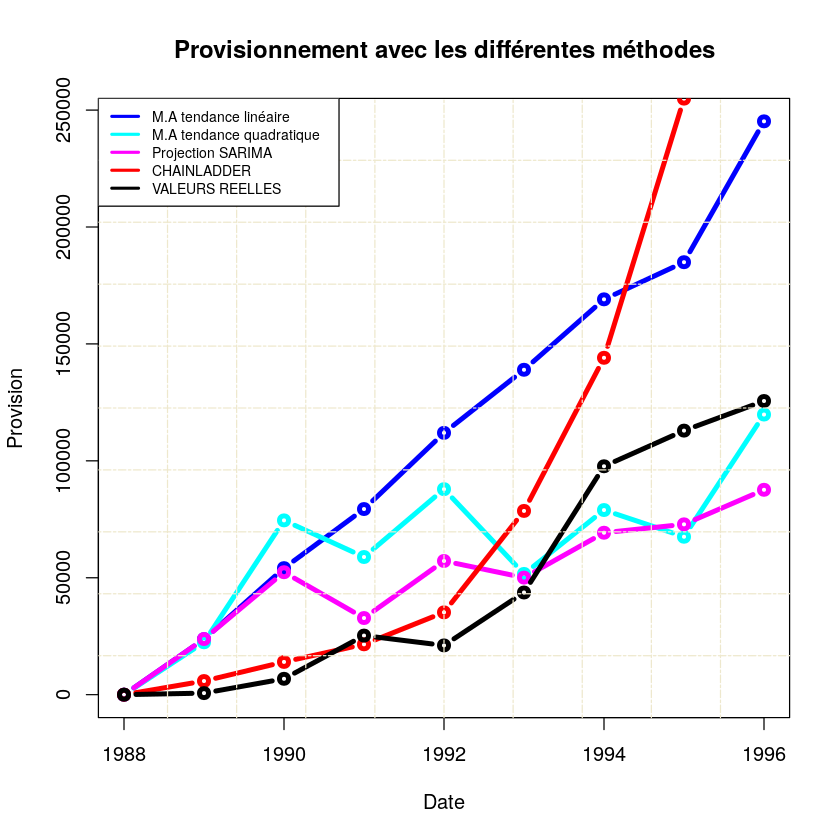

In [141]:
plot(1988:1996,Prov_st[,-10],type="b",ylab="Provision",xlab="Date",
     lwd=4,col=4,main="Provisionnement avec les différentes méthodes")
points(1988:1996,Prov_stq[,-10],type="b",lwd="4",col=5)
points(1988:1996,Prov_Pro[,-10],type="b",lwd="4",col=6)
points(1988:1996,Prov_ch[,-10],type="b",lwd="4",col=2)
points(1988:1996,Prov_r[,-10],type="b",lwd="4",col=9)
grid (10,10, lty = 6, col = "cornsilk2")
legend("topleft",c("M.A tendance linéaire","M.A tendance quadratique",
                    "Projection SARIMA","CHAINLADDER","VALEURS REELLES"),
       col=c(4,5,6,2,9),lty=c(1,1,1,1),lwd=c(2.5,2.5,2.5,2.5),cex=0.7)